In [1]:

from tqdm import tqdm
# from huggingface_hub import HfApi, ModelFilter, ModelSearchArguments, list_models
import json, requests
from multiprocessing import Pool
import json, pandas as pd, numpy as np, os
from datasets import load_dataset
import evaluate
import matplotlib.pyplot as plt, seaborn as sns

/home/vamsi.srivathsa/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-06-11 17:05:10.890730: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [17]:
df_models = pd.read_csv("sa_models_3_class_top_100_combined_with_prev_models.csv")

df_models['download_rank'] = df_models['downloads'].rank(ascending=False, method='min').astype(int)
df_models['like_rank'] = df_models['likes'].rank(ascending=False, method='min').astype(int)

df_models['lastModifiedDate'] = pd.to_datetime(df_models['lastModified'])
df_models['date_rank'] = df_models['lastModifiedDate'].rank(ascending=False, method='min').astype(int)

def returnDF(folder, dataset, category):
    df_models_sorted = df_models.sort_values('downloads', ascending=False)
    df_models_sorted['mname'] = [f'M'+str(i+1) for i in range(100)]
    path=f"hf_audit/results_combined/{dataset}/{folder}/{category}/"

    easy_cart_fnames = os.listdir(path)

    data=[]
    for fname in df_models_sorted.model:
        tname = fname.replace("/", "_")
        final_name = tname+'_scores.json'
        if final_name in easy_cart_fnames:
            with open(path+final_name, "r") as jfile:
                score_data = json.load(jfile)
                score_data["model"] = fname
                data.append(score_data)

    df_scores_easy_cart = pd.DataFrame(data)
    if folder=="before":df_scores_easy_cart['f1_rank'] = df_scores_easy_cart['f1'].rank(ascending=False, method='min').astype(int)
    else:df_scores_easy_cart['f1_rank'] = df_scores_easy_cart['test_f1'].rank(ascending=False, method='min').astype(int)
    merged_df = pd.merge(df_scores_easy_cart, df_models_sorted, on='model', how='inner')
    
    return merged_df

#before: evaluate
#after: finetune

te_be=returnDF("before", "tweet_eval", "easy")
te_ae=returnDF("after", "tweet_eval", "easy")

te_ba=returnDF("before", "tweet_eval", "ambi")
te_aa=returnDF("after", "tweet_eval", "ambi")

te_bh=returnDF("before", "tweet_eval", "hard")
te_ah=returnDF("after", "tweet_eval", "hard")

amr_be=returnDF("before", "amazon_multi_reviews", "easy")
amr_ae=returnDF("after", "amazon_multi_reviews", "easy")

amr_ba=returnDF("before", "amazon_multi_reviews", "ambi")
amr_aa=returnDF("after", "amazon_multi_reviews", "ambi")

amr_bh=returnDF("before", "amazon_multi_reviews", "hard")
amr_ah=returnDF("after", "amazon_multi_reviews", "hard")

fp_be=returnDF("before", "financial_phrasebank", "easy")
fp_ae=returnDF("after", "financial_phrasebank", "easy")

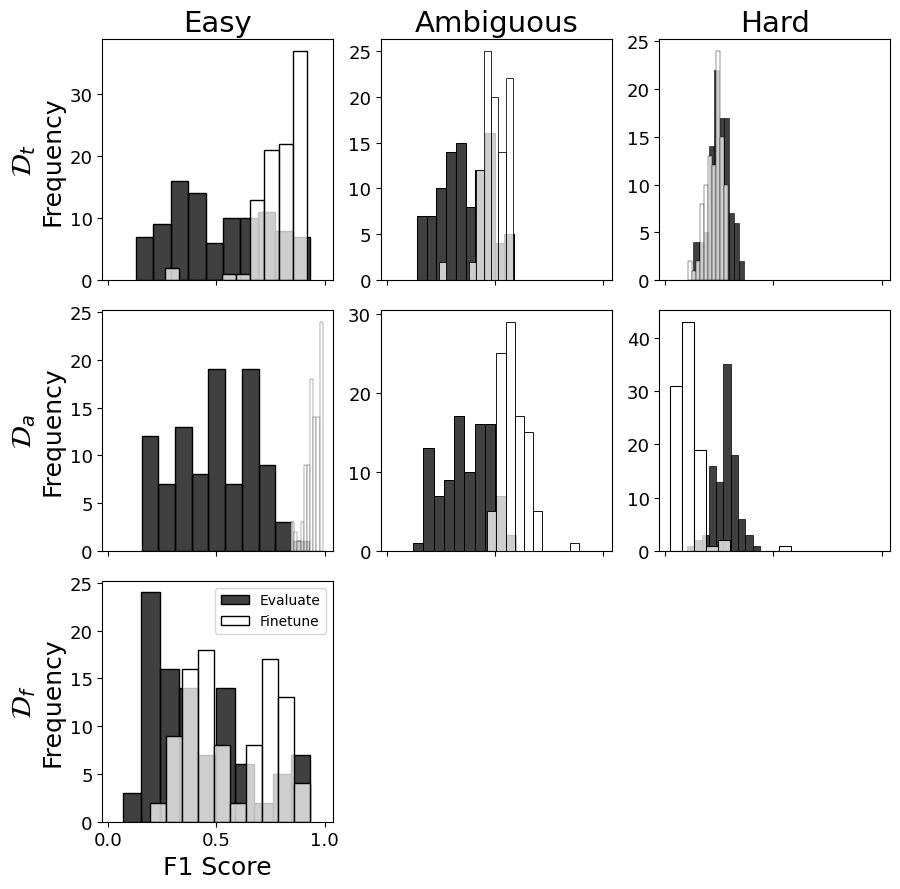

In [18]:

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Ignore the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")


categories = ['TE', 'AMR', 'FP']

colors=['black','white']


fig, axes = plt.subplots(3, 3, sharex=True, figsize=(9, 9))  # Changed from (3, 3) to (3, 2)

for i, category in enumerate(categories):
    eval_suffix = 'f1'
    finetune_suffix = 'test_f1'

    if category != "FP":
        for j, split in enumerate([('be', 'ae'), ('ba', 'aa'), ('bh', 'ah')]):
            df_eval = globals()[f'{category.lower()}_{split[0]}']
            df_finetune = globals()[f'{category.lower()}_{split[1]}']

            if 'e' in list(split[0]): cat = 'Easy'
            elif 'a' in list(split[0]): cat = 'Ambiguous'
            else: cat = 'Hard'

            # Plot the distribution
            sns.histplot(df_eval[eval_suffix].values, ax=axes[i, j], color=colors[0],  label="Evaluate", bins=10)
            sns.histplot(df_finetune[finetune_suffix].values, ax=axes[i, j], color=colors[1]  ,label="Finetune", bins=10)

            axes[i, j].set_xlabel('F1 Score',fontsize=18)
            if j != 0:  # Remove 'Frequency' label for columns other than the first column
                axes[i, j].set_ylabel('')
            else: axes[i, j].set_ylabel('Frequency', fontsize=18)
#             axes[i, j].legend(fontsize=10)
            axes[i, j].tick_params(axis='x', labelsize=13)
            axes[i, j].tick_params(axis='y', labelsize=13)
    else:
        for j, split in enumerate([('be', 'ae')]):
            df_eval = globals()[f'{category.lower()}_{split[0]}']
            df_finetune = globals()[f'{category.lower()}_{split[1]}']

            if 'e' in list(split[0]): cat = 'Easy'
            elif 'a' in list(split[0]): cat = 'Ambiguous'
            else: cat = 'Hard'

            # Plot the distribution
            sns.histplot(df_eval[eval_suffix].values, ax=axes[i, j], color=colors[0],label="Evaluate", bins=10)
            sns.histplot(df_finetune[finetune_suffix].values, ax=axes[i, j], color=colors[1] , label="Finetune", bins=10)

            axes[i, j].set_xlabel('F1 Score', fontsize=18)
            if j != 0:  # Remove 'Frequency' label for columns other than the first column
                axes[i, j].set_ylabel('')
            else: axes[i, j].set_ylabel('Frequency', fontsize=18)
            axes[i, j].legend(fontsize=10)
            axes[i, j].tick_params(axis='x', labelsize=13)
            axes[i, j].tick_params(axis='y', labelsize=13)

# Remove the empty subplots at (2,1) and (2,2)
fig.delaxes(axes[2, 1])
fig.delaxes(axes[2, 2])

# Name the columns
axes[0, 0].set_title('Easy', fontsize=21)
axes[0, 1].set_title('Ambiguous', fontsize=21)
axes[0, 2].set_title('Hard',fontsize=21)  # Removed this subplot

# Add labels to the left of the y-axis
for i, category in enumerate(categories):
    if category == "TE":
        label_name = r'$\mathcal{D}_{t}$'
    elif category == "FP":
        label_name = r'$\mathcal{D}_{f}$'
    else:
        label_name = r'$\mathcal{D}_{a}$'

    axes[i, 0].text(-0.4, 0.5, label_name, transform=axes[i, 0].transAxes, fontsize=20, va='center', rotation=90)


# Adjust layout
plt.tight_layout()
# plt.savefig("plots/dist_f1_all_vbw2.pdf", dpi=300)

# Show the plot
plt.show()


In [16]:
in_domain_models = (['cardiffnlp/twitter-roberta-base-sentiment-latest',
  'cardiffnlp/twitter-xlm-roberta-base-sentiment',
  'cardiffnlp/twitter-roberta-base-sentiment',
  'finiteautomata/beto-sentiment-analysis',
  'finiteautomata/bertweet-base-sentiment-analysis',
  'cardiffnlp/twitter-xlm-roberta-base-sentiment-multilingual',
  'cardiffnlp/camembert-base-tweet-sentiment-fr',
  'j-hartmann/sentiment-roberta-large-english-3-classes',
  'neuraly/bert-base-italian-cased-sentiment',
  'citizenlab/twitter-xlm-roberta-base-sentiment-finetunned',
  'alexandrainst/da-sentiment-base',
  'shashanksrinath/News_Sentiment_Analysis'],
 ['mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis',
  'ahmedrachid/FinancialBERT-Sentiment-Analysis',
  'soleimanian/financial-roberta-large-sentiment',
  'hw2942/bert-base-chinese-finetuning-financial-news-sentiment-v2',
  'Sigma/financial-sentiment-analysis',
  'Jean-Baptiste/roberta-large-financial-news-sentiment-en'],
 ['philschmid/distilbert-base-multilingual-cased-sentiment-2',
  'poom-sci/WangchanBERTa-finetuned-sentiment',
  'blanchefort/rubert-base-cased-sentiment-rurewiews',
  'christian-phu/bert-finetuned-japanese-sentiment',
  'philschmid/distilbert-base-multilingual-cased-sentiment-2',
  'Voicelab/herbert-base-cased-sentiment'])

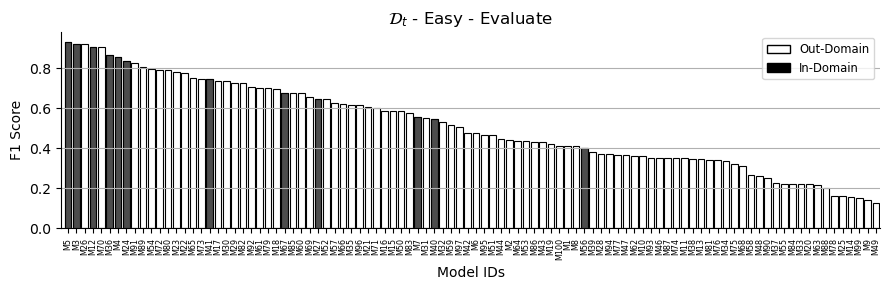

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

df_perf = te_be  # Assuming you have loaded your DataFrame

colors = ['cornflowerblue', 'salmonred']

highlighted_models = in_domain_models[0]

df_perf = df_perf.sort_values(by='f1', ascending=False)

# Adjust bar width and spacing
bar_width = 0.8
bar_spacing = 0

plt.figure(figsize=(9, 3))

# Use Seaborn to create the barplot
sns.barplot(x='mname', y='f1', data=df_perf, color=colors[0], alpha=1.0, label='Out-Domain',
            edgecolor='black', linewidth=0.8, width=bar_width)

# Color specific bars differently
for i, model in enumerate(df_perf['model']):
    if model in highlighted_models:
        plt.bar(i + bar_spacing, df_perf['f1'].values[i], color=colors[1], alpha=0.7,
                edgecolor='black', linewidth=0.8, width=bar_width)

# Customize the plot using Seaborn
plt.xlabel('Model IDs')
plt.ylabel('F1 Score')
plt.xticks(fontsize=5.8, rotation=90)

# Define custom legend handles with hatch patterns
out_domain_patch = mpatches.Patch(facecolor=colors[0],  edgecolor='black', label='Out-Domain')
in_domain_patch = mpatches.Patch(facecolor=colors[1],  edgecolor='black', label='In-Domain')

# Create the legend with the custom handles
plt.legend(handles=[out_domain_patch, in_domain_patch], loc='upper right', fontsize='small')

plt.grid(axis='y')
sns.despine()

# Show the plot
plt.title(r"$\mathcal{D}_{t}$ - Easy - Evaluate")
# plt.title(r"$\mathcal{D}_{a}$ - Ambi - Evaluate")
# plt.title(r"$\mathcal{D}_{a}$ - Hard - Evaluate")
plt.tight_layout()
# plt.savefig("plots/barplot_fp_be_vbw.pdf", dpi=300)
plt.xlim(-0.8, (df_perf.shape[0]) - 0.5)
plt.show()


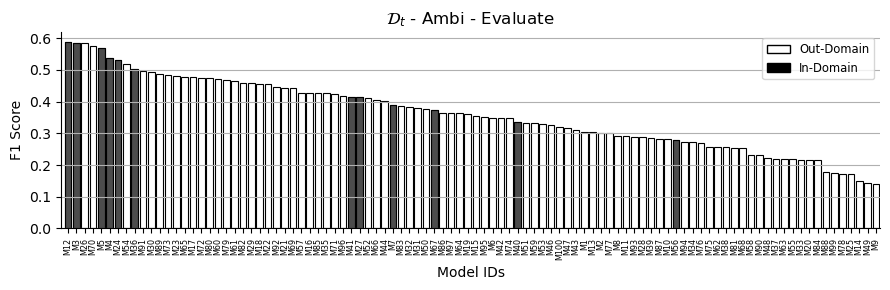

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

df_perf = te_ba  # Assuming you have loaded your DataFrame

colors = ['white', 'black']

highlighted_models = in_domain_models[0]

df_perf = df_perf.sort_values(by='f1', ascending=False)

# Adjust bar width and spacing
bar_width = 0.8
bar_spacing = 0

plt.figure(figsize=(9, 3))

# Use Seaborn to create the barplot
sns.barplot(x='mname', y='f1', data=df_perf, color=colors[0], alpha=1.0, label='Out-Domain',
            edgecolor='black', linewidth=0.8, width=bar_width)

# Color specific bars differently
for i, model in enumerate(df_perf['model']):
    if model in highlighted_models:
        plt.bar(i + bar_spacing, df_perf['f1'].values[i], color=colors[1], alpha=0.7,
                edgecolor='black', linewidth=0.8, width=bar_width)

# Customize the plot using Seaborn
plt.xlabel('Model IDs')
plt.ylabel('F1 Score')
plt.xticks(fontsize=5.8, rotation=90)

# Define custom legend handles with hatch patterns
out_domain_patch = mpatches.Patch(facecolor=colors[0],  edgecolor='black', label='Out-Domain')
in_domain_patch = mpatches.Patch(facecolor=colors[1],  edgecolor='black', label='In-Domain')

# Create the legend with the custom handles
plt.legend(handles=[out_domain_patch, in_domain_patch], loc='upper right', fontsize='small')

plt.grid(axis='y')
sns.despine()

# Show the plot
# plt.title(r"$\mathcal{D}_{t}$ - Easy - Evaluate")
plt.title(r"$\mathcal{D}_{t}$ - Ambi - Evaluate")
# plt.title(r"$\mathcal{D}_{a}$ - Hard - Evaluate")
plt.tight_layout()
# plt.savefig("plots/barplot_fp_be_vbw.pdf", dpi=300)
plt.xlim(-0.8, (df_perf.shape[0]) - 0.5)
plt.show()


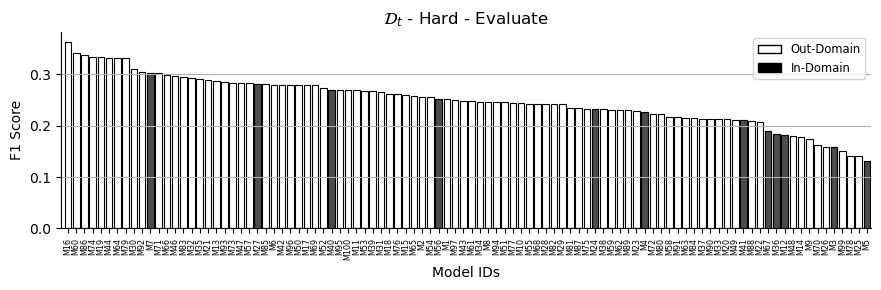

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

df_perf = te_bh  # Assuming you have loaded your DataFrame

colors = ['white', 'black']

highlighted_models = in_domain_models[0]

df_perf = df_perf.sort_values(by='f1', ascending=False)

# Adjust bar width and spacing
bar_width = 0.8
bar_spacing = 0

plt.figure(figsize=(9, 3))

# Use Seaborn to create the barplot
sns.barplot(x='mname', y='f1', data=df_perf, color=colors[0], alpha=1.0, label='Out-Domain',
            edgecolor='black', linewidth=0.8, width=bar_width)

# Color specific bars differently
for i, model in enumerate(df_perf['model']):
    if model in highlighted_models:
        plt.bar(i + bar_spacing, df_perf['f1'].values[i], color=colors[1], alpha=0.7,
                edgecolor='black', linewidth=0.8, width=bar_width)

# Customize the plot using Seaborn
plt.xlabel('Model IDs')
plt.ylabel('F1 Score')
plt.xticks(fontsize=5.8, rotation=90)

# Define custom legend handles with hatch patterns
out_domain_patch = mpatches.Patch(facecolor=colors[0],  edgecolor='black', label='Out-Domain')
in_domain_patch = mpatches.Patch(facecolor=colors[1],  edgecolor='black', label='In-Domain')

# Create the legend with the custom handles
plt.legend(handles=[out_domain_patch, in_domain_patch], loc='upper right', fontsize='small')

plt.grid(axis='y')
sns.despine()

# Show the plot
# plt.title(r"$\mathcal{D}_{t}$ - Easy - Evaluate")
# plt.title(r"$\mathcal{D}_{a}$ - Ambi - Evaluate")
plt.title(r"$\mathcal{D}_{t}$ - Hard - Evaluate")
plt.tight_layout()
# plt.savefig("plots/barplot_fp_be_vbw.pdf", dpi=300)
plt.xlim(-0.8, (df_perf.shape[0]) - 0.5)
plt.show()


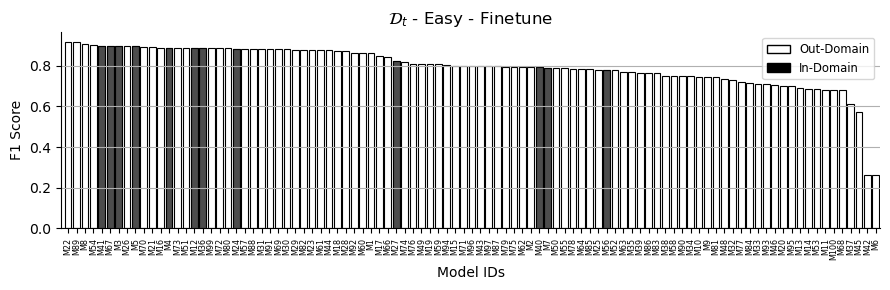

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

df_perf = te_ae  # Assuming you have loaded your DataFrame

colors = ['white', 'black']

highlighted_models = in_domain_models[0]

df_perf = df_perf.sort_values(by='test_f1', ascending=False)

# Adjust bar width and spacing
bar_width = 0.8
bar_spacing = 0

plt.figure(figsize=(9, 3))

# Use Seaborn to create the barplot
sns.barplot(x='mname', y='test_f1', data=df_perf, color=colors[0], alpha=1.0, label='Out-Domain',
            edgecolor='black', linewidth=0.8, width=bar_width)

# Color specific bars differently
for i, model in enumerate(df_perf['model']):
    if model in highlighted_models:
        plt.bar(i + bar_spacing, df_perf['test_f1'].values[i], color=colors[1], alpha=0.7,
                edgecolor='black', linewidth=0.8, width=bar_width)

# Customize the plot using Seaborn
plt.xlabel('Model IDs')
plt.ylabel('F1 Score')
plt.xticks(fontsize=5.8, rotation=90)

# Define custom legend handles with hatch patterns
out_domain_patch = mpatches.Patch(facecolor=colors[0],  edgecolor='black', label='Out-Domain')
in_domain_patch = mpatches.Patch(facecolor=colors[1],  edgecolor='black', label='In-Domain')

# Create the legend with the custom handles
plt.legend(handles=[out_domain_patch, in_domain_patch], loc='upper right', fontsize='small')

plt.grid(axis='y')
sns.despine()

# Show the plot
plt.title(r"$\mathcal{D}_{t}$ - Easy - Finetune")
# plt.title(r"$\mathcal{D}_{a}$ - Ambi - Finetune")
# plt.title(r"$\mathcal{D}_{a}$ - Hard - Finetune")
plt.tight_layout()
# plt.savefig("plots/barplot_fp_ae_vbw.pdf", dpi=300)
plt.xlim(-0.8, (df_perf.shape[0]) - 0.5)
plt.show()


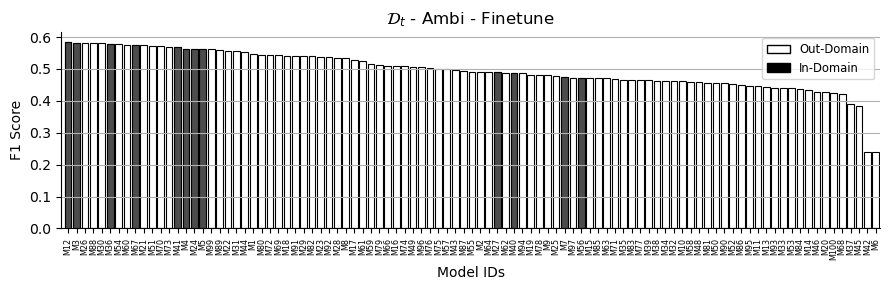

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

df_perf = te_aa  # Assuming you have loaded your DataFrame

colors = ['white', 'black']

highlighted_models = in_domain_models[0]

df_perf = df_perf.sort_values(by='test_f1', ascending=False)

# Adjust bar width and spacing
bar_width = 0.8
bar_spacing = 0

plt.figure(figsize=(9, 3))

# Use Seaborn to create the barplot
sns.barplot(x='mname', y='test_f1', data=df_perf, color=colors[0], alpha=1.0, label='Out-Domain',
            edgecolor='black', linewidth=0.8, width=bar_width)

# Color specific bars differently
for i, model in enumerate(df_perf['model']):
    if model in highlighted_models:
        plt.bar(i + bar_spacing, df_perf['test_f1'].values[i], color=colors[1], alpha=0.7,
                edgecolor='black', linewidth=0.8, width=bar_width)

# Customize the plot using Seaborn
plt.xlabel('Model IDs')
plt.ylabel('F1 Score')
plt.xticks(fontsize=5.8, rotation=90)

# Define custom legend handles with hatch patterns
out_domain_patch = mpatches.Patch(facecolor=colors[0],  edgecolor='black', label='Out-Domain')
in_domain_patch = mpatches.Patch(facecolor=colors[1],  edgecolor='black', label='In-Domain')

# Create the legend with the custom handles
plt.legend(handles=[out_domain_patch, in_domain_patch], loc='upper right', fontsize='small')

plt.grid(axis='y')
sns.despine()

# Show the plot
# plt.title(r"$\mathcal{D}_{f}$ - Easy - Finetune")
plt.title(r"$\mathcal{D}_{t}$ - Ambi - Finetune")
# plt.title(r"$\mathcal{D}_{a}$ - Hard - Finetune")
plt.tight_layout()
# plt.savefig("plots/barplot_fp_ae_vbw.pdf", dpi=300)
plt.xlim(-0.8, (df_perf.shape[0]) - 0.5)
plt.show()


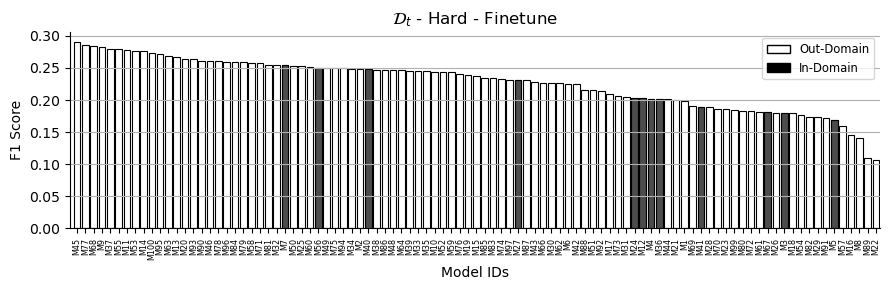

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

df_perf = te_ah  # Assuming you have loaded your DataFrame

colors = ['white', 'black']

highlighted_models = in_domain_models[0]

df_perf = df_perf.sort_values(by='test_f1', ascending=False)

# Adjust bar width and spacing
bar_width = 0.8
bar_spacing = 0

plt.figure(figsize=(9, 3))

# Use Seaborn to create the barplot
sns.barplot(x='mname', y='test_f1', data=df_perf, color=colors[0], alpha=1.0, label='Out-Domain',
            edgecolor='black', linewidth=0.8, width=bar_width)

# Color specific bars differently
for i, model in enumerate(df_perf['model']):
    if model in highlighted_models:
        plt.bar(i + bar_spacing, df_perf['test_f1'].values[i], color=colors[1], alpha=0.7,
                edgecolor='black', linewidth=0.8, width=bar_width)

# Customize the plot using Seaborn
plt.xlabel('Model IDs')
plt.ylabel('F1 Score')
plt.xticks(fontsize=5.8, rotation=90)

# Define custom legend handles with hatch patterns
out_domain_patch = mpatches.Patch(facecolor=colors[0],  edgecolor='black', label='Out-Domain')
in_domain_patch = mpatches.Patch(facecolor=colors[1],  edgecolor='black', label='In-Domain')

# Create the legend with the custom handles
plt.legend(handles=[out_domain_patch, in_domain_patch], loc='upper right', fontsize='small')

plt.grid(axis='y')
sns.despine()

# Show the plot
# plt.title(r"$\mathcal{D}_{f}$ - Easy - Finetune")
# plt.title(r"$\mathcal{D}_{t}$ - Ambi - Finetune")
plt.title(r"$\mathcal{D}_{t}$ - Hard - Finetune")
plt.tight_layout()
# plt.savefig("plots/barplot_fp_ae_vbw.pdf", dpi=300)
plt.xlim(-0.8, (df_perf.shape[0]) - 0.5)
plt.show()


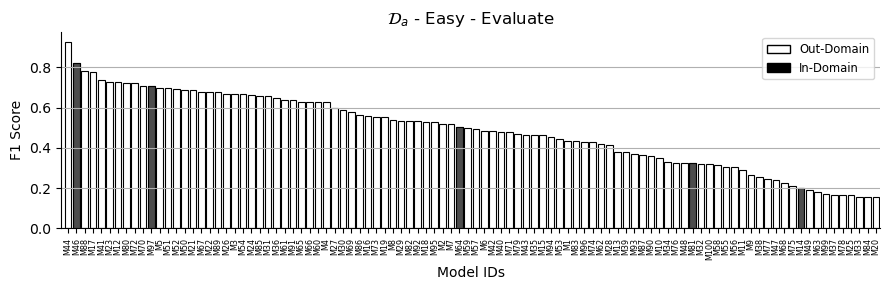

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

df_perf = amr_be  # Assuming you have loaded your DataFrame

colors = ['white', 'black']

highlighted_models = in_domain_models[2]

df_perf = df_perf.sort_values(by='f1', ascending=False)

# Adjust bar width and spacing
bar_width = 0.8
bar_spacing = 0

plt.figure(figsize=(9, 3))

# Use Seaborn to create the barplot
sns.barplot(x='mname', y='f1', data=df_perf, color=colors[0], alpha=1.0, label='Out-Domain',
            edgecolor='black', linewidth=0.8, width=bar_width)

# Color specific bars differently
for i, model in enumerate(df_perf['model']):
    if model in highlighted_models:
        plt.bar(i + bar_spacing, df_perf['f1'].values[i], color=colors[1], alpha=0.7,
                edgecolor='black', linewidth=0.8, width=bar_width)

# Customize the plot using Seaborn
plt.xlabel('Model IDs')
plt.ylabel('F1 Score')
plt.xticks(fontsize=5.8, rotation=90)

# Define custom legend handles with hatch patterns
out_domain_patch = mpatches.Patch(facecolor=colors[0],  edgecolor='black', label='Out-Domain')
in_domain_patch = mpatches.Patch(facecolor=colors[1],  edgecolor='black', label='In-Domain')

# Create the legend with the custom handles
plt.legend(handles=[out_domain_patch, in_domain_patch], loc='upper right', fontsize='small')

plt.grid(axis='y')
sns.despine()

# Show the plot
plt.title(r"$\mathcal{D}_{a}$ - Easy - Evaluate")
# plt.title(r"$\mathcal{D}_{a}$ - Ambi - Evaluate")
# plt.title(r"$\mathcal{D}_{a}$ - Hard - Evaluate")
plt.tight_layout()
# plt.savefig("plots/barplot_fp_be_vbw.pdf", dpi=300)
plt.xlim(-0.8, (df_perf.shape[0]) - 0.5)
plt.show()


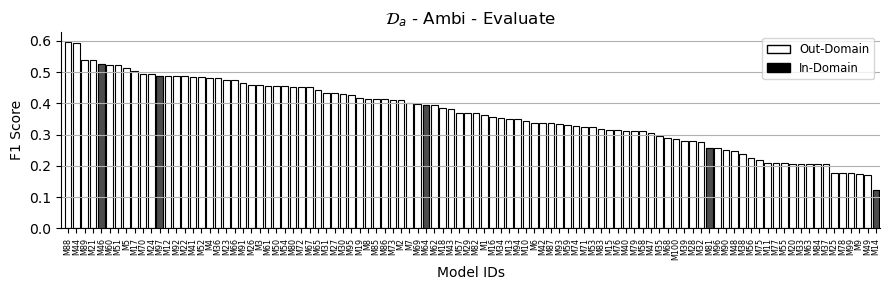

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

df_perf = amr_ba  # Assuming you have loaded your DataFrame

colors = ['white', 'black']

highlighted_models = in_domain_models[2]

df_perf = df_perf.sort_values(by='f1', ascending=False)

# Adjust bar width and spacing
bar_width = 0.8
bar_spacing = 0

plt.figure(figsize=(9, 3))

# Use Seaborn to create the barplot
sns.barplot(x='mname', y='f1', data=df_perf, color=colors[0], alpha=1.0, label='Out-Domain',
            edgecolor='black', linewidth=0.8, width=bar_width)

# Color specific bars differently
for i, model in enumerate(df_perf['model']):
    if model in highlighted_models:
        plt.bar(i + bar_spacing, df_perf['f1'].values[i], color=colors[1], alpha=0.7,
                edgecolor='black', linewidth=0.8, width=bar_width)

# Customize the plot using Seaborn
plt.xlabel('Model IDs')
plt.ylabel('F1 Score')
plt.xticks(fontsize=5.8, rotation=90)

# Define custom legend handles with hatch patterns
out_domain_patch = mpatches.Patch(facecolor=colors[0],  edgecolor='black', label='Out-Domain')
in_domain_patch = mpatches.Patch(facecolor=colors[1],  edgecolor='black', label='In-Domain')

# Create the legend with the custom handles
plt.legend(handles=[out_domain_patch, in_domain_patch], loc='upper right', fontsize='small')

plt.grid(axis='y')
sns.despine()

# Show the plot
# plt.title(r"$\mathcal{D}_{a}$ - Easy - Evaluate")
plt.title(r"$\mathcal{D}_{a}$ - Ambi - Evaluate")
# plt.title(r"$\mathcal{D}_{a}$ - Hard - Evaluate")
plt.tight_layout()
# plt.savefig("plots/barplot_fp_be_vbw.pdf", dpi=300)
plt.xlim(-0.8, (df_perf.shape[0]) - 0.5)
plt.show()


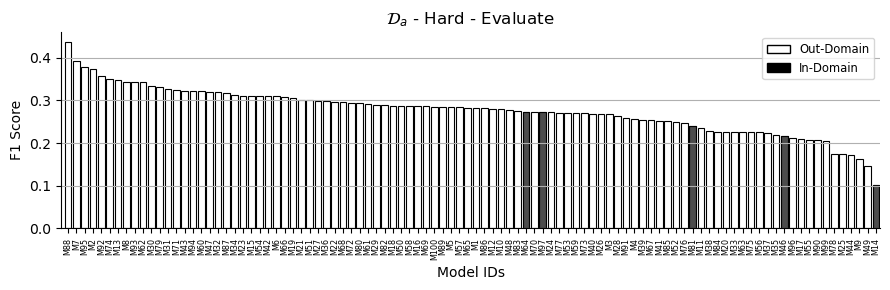

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

df_perf = amr_bh  # Assuming you have loaded your DataFrame

colors = ['white', 'black']

highlighted_models = in_domain_models[2]

df_perf = df_perf.sort_values(by='f1', ascending=False)

# Adjust bar width and spacing
bar_width = 0.8
bar_spacing = 0

plt.figure(figsize=(9, 3))

# Use Seaborn to create the barplot
sns.barplot(x='mname', y='f1', data=df_perf, color=colors[0], alpha=1.0, label='Out-Domain',
            edgecolor='black', linewidth=0.8, width=bar_width)

# Color specific bars differently
for i, model in enumerate(df_perf['model']):
    if model in highlighted_models:
        plt.bar(i + bar_spacing, df_perf['f1'].values[i], color=colors[1], alpha=0.7,
                edgecolor='black', linewidth=0.8, width=bar_width)

# Customize the plot using Seaborn
plt.xlabel('Model IDs')
plt.ylabel('F1 Score')
plt.xticks(fontsize=5.8, rotation=90)

# Define custom legend handles with hatch patterns
out_domain_patch = mpatches.Patch(facecolor=colors[0],  edgecolor='black', label='Out-Domain')
in_domain_patch = mpatches.Patch(facecolor=colors[1],  edgecolor='black', label='In-Domain')

# Create the legend with the custom handles
plt.legend(handles=[out_domain_patch, in_domain_patch], loc='upper right', fontsize='small')

plt.grid(axis='y')
sns.despine()

# Show the plot
# plt.title(r"$\mathcal{D}_{a}$ - Easy - Evaluate")
# plt.title(r"$\mathcal{D}_{a}$ - Ambi - Evaluate")
plt.title(r"$\mathcal{D}_{a}$ - Hard - Evaluate")
plt.tight_layout()
# plt.savefig("plots/barplot_fp_be_vbw.pdf", dpi=300)
plt.xlim(-0.8, (df_perf.shape[0]) - 0.5)
plt.show()


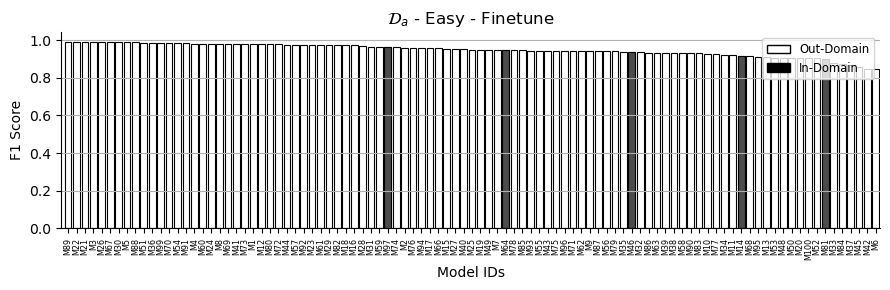

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

df_perf = amr_ae  # Assuming you have loaded your DataFrame

colors = ['white', 'black']

highlighted_models = in_domain_models[2]

df_perf = df_perf.sort_values(by='test_f1', ascending=False)

# Adjust bar width and spacing
bar_width = 0.8
bar_spacing = 0

plt.figure(figsize=(9, 3))

# Use Seaborn to create the barplot
sns.barplot(x='mname', y='test_f1', data=df_perf, color=colors[0], alpha=1.0, label='Out-Domain',
            edgecolor='black', linewidth=0.8, width=bar_width)

# Color specific bars differently
for i, model in enumerate(df_perf['model']):
    if model in highlighted_models:
        plt.bar(i + bar_spacing, df_perf['test_f1'].values[i], color=colors[1], alpha=0.7,
                edgecolor='black', linewidth=0.8, width=bar_width)

# Customize the plot using Seaborn
plt.xlabel('Model IDs')
plt.ylabel('F1 Score')
plt.xticks(fontsize=5.8, rotation=90)

# Define custom legend handles with hatch patterns
out_domain_patch = mpatches.Patch(facecolor=colors[0],  edgecolor='black', label='Out-Domain')
in_domain_patch = mpatches.Patch(facecolor=colors[1],  edgecolor='black', label='In-Domain')

# Create the legend with the custom handles
plt.legend(handles=[out_domain_patch, in_domain_patch], loc='upper right', fontsize='small')

plt.grid(axis='y')
sns.despine()

# Show the plot
plt.title(r"$\mathcal{D}_{a}$ - Easy - Finetune")
# plt.title(r"$\mathcal{D}_{t}$ - Ambi - Finetune")
# plt.title(r"$\mathcal{D}_{t}$ - Hard - Finetune")
plt.tight_layout()
# plt.savefig("plots/barplot_fp_ae_vbw.pdf", dpi=300)
plt.xlim(-0.8, (df_perf.shape[0]) - 0.5)
plt.show()


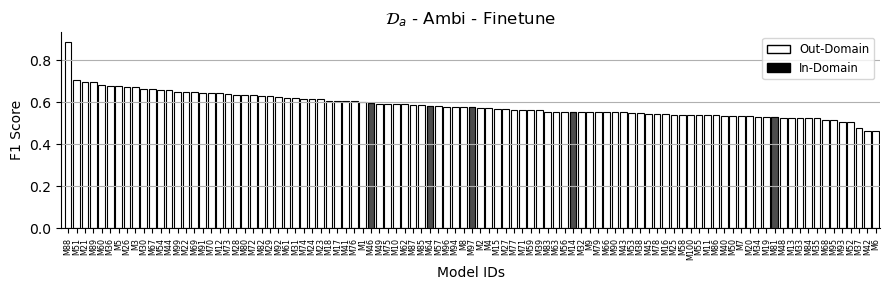

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

df_perf = amr_aa  # Assuming you have loaded your DataFrame

colors = ['white', 'black']

highlighted_models = in_domain_models[2]

df_perf = df_perf.sort_values(by='test_f1', ascending=False)

# Adjust bar width and spacing
bar_width = 0.8
bar_spacing = 0

plt.figure(figsize=(9, 3))

# Use Seaborn to create the barplot
sns.barplot(x='mname', y='test_f1', data=df_perf, color=colors[0], alpha=1.0, label='Out-Domain',
            edgecolor='black', linewidth=0.8, width=bar_width)

# Color specific bars differently
for i, model in enumerate(df_perf['model']):
    if model in highlighted_models:
        plt.bar(i + bar_spacing, df_perf['test_f1'].values[i], color=colors[1], alpha=0.7,
                edgecolor='black', linewidth=0.8, width=bar_width)

# Customize the plot using Seaborn
plt.xlabel('Model IDs')
plt.ylabel('F1 Score')
plt.xticks(fontsize=5.8, rotation=90)

# Define custom legend handles with hatch patterns
out_domain_patch = mpatches.Patch(facecolor=colors[0],  edgecolor='black', label='Out-Domain')
in_domain_patch = mpatches.Patch(facecolor=colors[1],  edgecolor='black', label='In-Domain')

# Create the legend with the custom handles
plt.legend(handles=[out_domain_patch, in_domain_patch], loc='upper right', fontsize='small')

plt.grid(axis='y')
sns.despine()

# Show the plot
# plt.title(r"$\mathcal{D}_{a}$ - Easy - Finetune")
plt.title(r"$\mathcal{D}_{a}$ - Ambi - Finetune")
# plt.title(r"$\mathcal{D}_{t}$ - Hard - Finetune")
plt.tight_layout()
# plt.savefig("plots/barplot_fp_ae_vbw.pdf", dpi=300)
plt.xlim(-0.8, (df_perf.shape[0]) - 0.5)
plt.show()


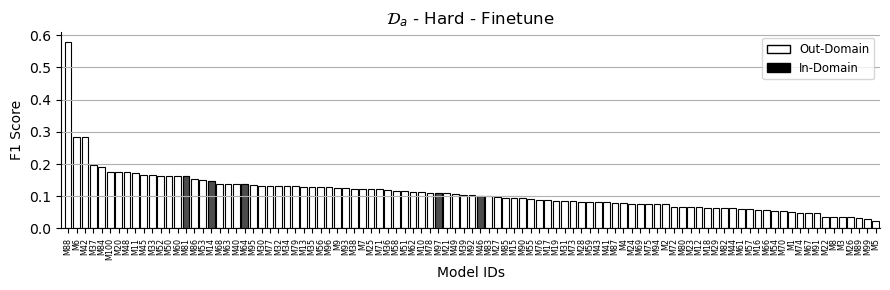

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

df_perf = amr_ah  # Assuming you have loaded your DataFrame

colors = ['white', 'black']

highlighted_models = in_domain_models[2]

df_perf = df_perf.sort_values(by='test_f1', ascending=False)

# Adjust bar width and spacing
bar_width = 0.8
bar_spacing = 0

plt.figure(figsize=(9, 3))

# Use Seaborn to create the barplot
sns.barplot(x='mname', y='test_f1', data=df_perf, color=colors[0], alpha=1.0, label='Out-Domain',
            edgecolor='black', linewidth=0.8, width=bar_width)

# Color specific bars differently
for i, model in enumerate(df_perf['model']):
    if model in highlighted_models:
        plt.bar(i + bar_spacing, df_perf['test_f1'].values[i], color=colors[1], alpha=0.7,
                edgecolor='black', linewidth=0.8, width=bar_width)

# Customize the plot using Seaborn
plt.xlabel('Model IDs')
plt.ylabel('F1 Score')
plt.xticks(fontsize=5.8, rotation=90)

# Define custom legend handles with hatch patterns
out_domain_patch = mpatches.Patch(facecolor=colors[0],  edgecolor='black', label='Out-Domain')
in_domain_patch = mpatches.Patch(facecolor=colors[1],  edgecolor='black', label='In-Domain')

# Create the legend with the custom handles
plt.legend(handles=[out_domain_patch, in_domain_patch], loc='upper right', fontsize='small')

plt.grid(axis='y')
sns.despine()

# Show the plot
# plt.title(r"$\mathcal{D}_{a}$ - Easy - Finetune")
# plt.title(r"$\mathcal{D}_{t}$ - Ambi - Finetune")
plt.title(r"$\mathcal{D}_{a}$ - Hard - Finetune")
plt.tight_layout()
# plt.savefig("plots/barplot_fp_ae_vbw.pdf", dpi=300)
plt.xlim(-0.8, (df_perf.shape[0]) - 0.5)
plt.show()


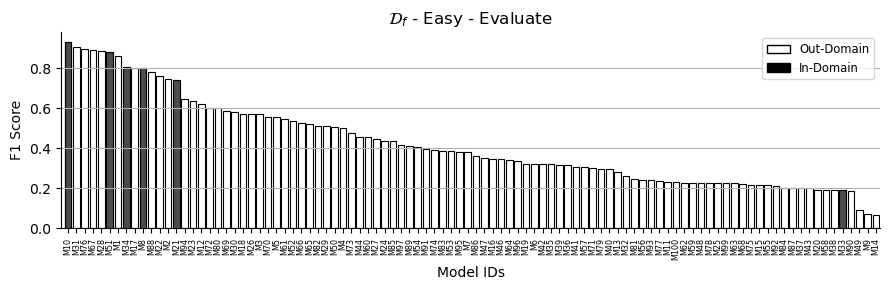

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

df_perf = fp_be  # Assuming you have loaded your DataFrame

colors = ['white', 'black']

highlighted_models = in_domain_models[1]

df_perf = df_perf.sort_values(by='f1', ascending=False)

# Adjust bar width and spacing
bar_width = 0.8
bar_spacing = 0

plt.figure(figsize=(9, 3))

# Use Seaborn to create the barplot
sns.barplot(x='mname', y='f1', data=df_perf, color=colors[0], alpha=1.0, label='Out-Domain',
            edgecolor='black', linewidth=0.8, width=bar_width)

# Color specific bars differently
for i, model in enumerate(df_perf['model']):
    if model in highlighted_models:
        plt.bar(i + bar_spacing, df_perf['f1'].values[i], color=colors[1], alpha=0.7,
                edgecolor='black', linewidth=0.8, width=bar_width)

# Customize the plot using Seaborn
plt.xlabel('Model IDs')
plt.ylabel('F1 Score')
plt.xticks(fontsize=5.8, rotation=90)

# Define custom legend handles with hatch patterns
out_domain_patch = mpatches.Patch(facecolor=colors[0],  edgecolor='black', label='Out-Domain')
in_domain_patch = mpatches.Patch(facecolor=colors[1],  edgecolor='black', label='In-Domain')

# Create the legend with the custom handles
plt.legend(handles=[out_domain_patch, in_domain_patch], loc='upper right', fontsize='small')

plt.grid(axis='y')
sns.despine()

# Show the plot
plt.title(r"$\mathcal{D}_{f}$ - Easy - Evaluate")
# plt.title(r"$\mathcal{D}_{a}$ - Ambi - Evaluate")
# plt.title(r"$\mathcal{D}_{a}$ - Hard - Evaluate")
plt.tight_layout()
# plt.savefig("plots/barplot_fp_be_vbw.pdf", dpi=300)
plt.xlim(-0.8, (df_perf.shape[0]) - 0.5)
plt.show()


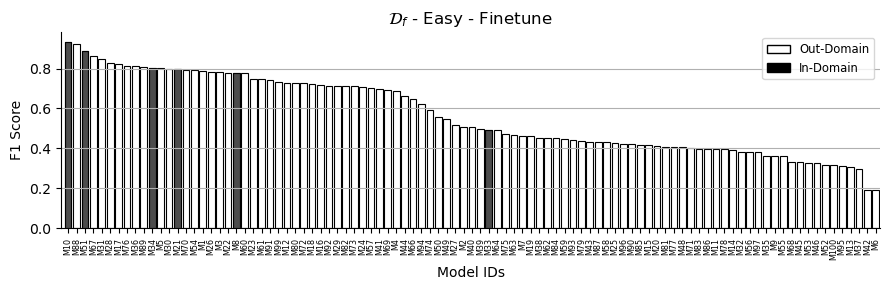

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

df_perf = fp_ae  # Assuming you have loaded your DataFrame

colors = ['white', 'black']

highlighted_models = in_domain_models[1]

df_perf = df_perf.sort_values(by='test_f1', ascending=False)

# Adjust bar width and spacing
bar_width = 0.8
bar_spacing = 0

plt.figure(figsize=(9, 3))

# Use Seaborn to create the barplot
sns.barplot(x='mname', y='test_f1', data=df_perf, color=colors[0], alpha=1.0, label='Out-Domain',
            edgecolor='black', linewidth=0.8, width=bar_width)

# Color specific bars differently
for i, model in enumerate(df_perf['model']):
    if model in highlighted_models:
        plt.bar(i + bar_spacing, df_perf['test_f1'].values[i], color=colors[1], alpha=0.7,
                edgecolor='black', linewidth=0.8, width=bar_width)

# Customize the plot using Seaborn
plt.xlabel('Model IDs')
plt.ylabel('F1 Score')
plt.xticks(fontsize=5.8, rotation=90)

# Define custom legend handles with hatch patterns
out_domain_patch = mpatches.Patch(facecolor=colors[0],  edgecolor='black', label='Out-Domain')
in_domain_patch = mpatches.Patch(facecolor=colors[1],  edgecolor='black', label='In-Domain')

# Create the legend with the custom handles
plt.legend(handles=[out_domain_patch, in_domain_patch], loc='upper right', fontsize='small')

plt.grid(axis='y')
sns.despine()

# Show the plot
plt.title(r"$\mathcal{D}_{f}$ - Easy - Finetune")
# plt.title(r"$\mathcal{D}_{t}$ - Ambi - Finetune")
# plt.title(r"$\mathcal{D}_{a}$ - Hard - Finetune")
plt.tight_layout()
# plt.savefig("plots/barplot_fp_ae_vbw.pdf", dpi=300)
plt.xlim(-0.8, (df_perf.shape[0]) - 0.5)
plt.show()
